# Method 5 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

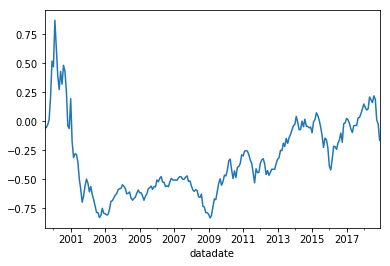

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.518646
2000-12-31   -0.382558
2001-12-31   -0.464681
2002-12-31   -0.586940
2003-12-31    1.031802
2004-12-31   -0.032041
2005-12-31    0.066187
2006-12-31    0.139714
2007-12-31   -0.018174
2008-12-31   -0.564273
2009-12-31    1.530433
2010-12-31    0.326217
2011-12-31   -0.213997
2012-12-31    0.137334
2013-12-31    0.511948
2014-12-31   -0.012375
2015-12-31   -0.191356
2016-12-31    0.283055
2017-12-31    0.122103
2018-12-31   -0.243797
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     272.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.16e-86
Time:                        04:15:30   Log-Likelihood:                 394.48
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      0.898      0.370      -0.003       0.009
mktrf          1.3334      0.085     15.774      0.000       1.167       1.500
me             0.5674      0.098      5.770      0.000       0.374       0.761
ia            -0.2436      0.149     -1.630      0.104      -0.538       0.051
roe           -1.3301      0.128    -10.398      0.000      -1.582      -1.078
==============================================================================
Omnibus:                      124.383   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1667.576
Skew:                           1.729   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     89.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-45
Time:                        04:15:30   Log-Likelihood:                 394.48
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      0.805      0.421      -0.004       0.010
mktrf          1.3334      0.157      8.478      0.000       1.025       1.642
me             0.5674      0.108      5.240      0.000       0.355       0.780
ia            -0.2436      0.203     -1.203      0.229      -0.641       0.153
roe           -1.3301      0.191     -6.967      0.000      -1.704      -0.956
==============================================================================
Omnibus:                      124.383   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1667.576
Skew:                           1.729   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     107.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.54e-51
Time:                        04:15:30   Log-Likelihood:                 394.48
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.004      0.768      0.443      -0.004       0.010
mktrf          1.3334      0.158      8.435      0.000       1.024       1.643
me             0.5674      0.128      4.446      0.000       0.317       0.818
ia            -0.2436      0.188     -1.298      0.194      -0.611       0.124
roe           -1.3301      0.204     -6.508      0.000      -1.731      -0.930
==============================================================================
Omnibus:                      124.383   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1667.576
Skew:                           1.729   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     189.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.73e-79
Time:                        04:15:30   Log-Likelihood:                 381.51
No. Observations:                 234   AIC:                            -751.0
Df Residuals:                     228   BIC:                            -730.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.514      0.608      -0.005       0.008
mktrf          1.4733      0.090     16.421      0.000       1.296       1.650
smb            0.5996      0.118      5.065      0.000       0.366       0.833
hml            0.1189      0.140      0.852      0.395      -0.156       0.394
rmw           -1.2084      0.158     -7.656      0.000      -1.519      -0.897
cma           -0.0932      0.201     -0.465      0.643      -0.489       0.302
==============================================================================
Omnibus:                      112.544   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.333
Skew:                           1.792   Prob(JB):                    1.26e-155
Kurtosis:                      10.766   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     96.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.59e-54
Time:                        04:15:30   Log-Likelihood:                 381.51
No. Observations:                 234   AIC:                            -751.0
Df Residuals:                     228   BIC:                            -730.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.507      0.612      -0.005       0.008
mktrf          1.4733      0.106     13.960      0.000       1.266       1.680
smb            0.5996      0.110      5.428      0.000       0.383       0.816
hml            0.1189      0.245      0.485      0.628      -0.361       0.599
rmw           -1.2084      0.209     -5.793      0.000      -1.617      -0.800
cma           -0.0932      0.298     -0.313      0.754      -0.677       0.491
==============================================================================
Omnibus:                      112.544   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.333
Skew:                           1.792   Prob(JB):                    1.26e-155
Kurtosis:                      10.766   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     123.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.73e-63
Time:                        04:15:30   Log-Likelihood:                 381.51
No. Observations:                 234   AIC:                            -751.0
Df Residuals:                     228   BIC:                            -730.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.004      0.474      0.635      -0.005       0.009
mktrf          1.4733      0.093     15.903      0.000       1.292       1.655
smb            0.5996      0.114      5.256      0.000       0.376       0.823
hml            0.1189      0.210      0.565      0.572      -0.293       0.531
rmw           -1.2084      0.229     -5.284      0.000      -1.657      -0.760
cma           -0.0932      0.280     -0.333      0.739      -0.642       0.456
==============================================================================
Omnibus:                      112.544   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              713.333
Skew:                           1.792   Prob(JB):                    1.26e-155
Kurtosis:                      10.766   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     241.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.19e-81
Time:                        04:15:30   Log-Likelihood:                 382.69
No. Observations:                 234   AIC:                            -755.4
Df Residuals:                     229   BIC:                            -738.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.003     -0.564      0.573      -0.008       0.004
mktrf          1.5460      0.082     18.888      0.000       1.385       1.707
smb            1.1681      0.102     11.433      0.000       0.967       1.369
hml           -0.2525      0.101     -2.488      0.014      -0.453      -0.053
umd           -0.5099      0.067     -7.657      0.000      -0.641      -0.379
==============================================================================
Omnibus:                       92.783   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.390
Skew:                           1.337   Prob(JB):                    2.03e-155
Kurtosis:                      11.119   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     120.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.16e-55
Time:                        04:15:30   Log-Likelihood:                 382.69
No. Observations:                 234   AIC:                            -755.4
Df Residuals:                     229   BIC:                            -738.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.003     -0.537      0.591      -0.008       0.005
mktrf          1.5460      0.127     12.172      0.000       1.297       1.795
smb            1.1681      0.091     12.880      0.000       0.990       1.346
hml           -0.2525      0.158     -1.599      0.110      -0.562       0.057
umd           -0.5099      0.099     -5.164      0.000      -0.703      -0.316
==============================================================================
Omnibus:                       92.783   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.390
Skew:                           1.337   Prob(JB):                    2.03e-155
Kurtosis:                      11.119   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     120.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.25e-55
Time:                        04:15:30   Log-Likelihood:                 382.69
No. Observations:                 234   AIC:                            -755.4
Df Residuals:                     229   BIC:                            -738.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.003     -0.532      0.595      -0.008       0.005
mktrf          1.5460      0.119     12.943      0.000       1.312       1.780
smb            1.1681      0.092     12.689      0.000       0.988       1.349
hml           -0.2525      0.151     -1.677      0.094      -0.548       0.043
umd           -0.5099      0.096     -5.308      0.000      -0.698      -0.322
==============================================================================
Omnibus:                       92.783   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.390
Skew:                           1.337   Prob(JB):                    2.03e-155
Kurtosis:                      11.119   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     121.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.36e-40
Time:                        04:15:30   Log-Likelihood:                 177.22
No. Observations:                 120   AIC:                            -344.4
Df Residuals:                     115   BIC:                            -330.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.201      0.232      -0.004       0.017
mktrf          1.1864      0.145      8.155      0.000       0.898       1.475
me             0.4458      0.144      3.102      0.002       0.161       0.730
ia            -0.4609      0.225     -2.048      0.043      -0.907      -0.015
roe           -1.3933      0.199     -6.996      0.000      -1.788      -0.999
==============================================================================
Omnibus:                       47.117   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.758
Skew:                           1.201   Prob(JB):                     8.65e-53
Kurtosis:                       9.495   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     68.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.36e-29
Time:                        04:15:30   Log-Likelihood:                 177.22
No. Observations:                 120   AIC:                            -344.4
Df Residuals:                     115   BIC:                            -330.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.224      0.221      -0.004       0.017
mktrf          1.1864      0.234      5.068      0.000       0.728       1.645
me             0.4458      0.143      3.128      0.002       0.166       0.725
ia            -0.4609      0.294     -1.568      0.117      -1.037       0.115
roe           -1.3933      0.274     -5.082      0.000      -1.931      -0.856
==============================================================================
Omnibus:                       47.117   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.758
Skew:                           1.201   Prob(JB):                     8.65e-53
Kurtosis:                       9.495   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     90.62
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-34
Time:                        04:15:30   Log-Likelihood:                 177.22
No. Observations:                 120   AIC:                            -344.4
Df Residuals:                     115   BIC:                            -330.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.005      1.288      0.198      -0.003       0.016
mktrf          1.1864      0.238      4.991      0.000       0.721       1.652
me             0.4458      0.164      2.723      0.006       0.125       0.767
ia            -0.4609      0.274     -1.682      0.093      -0.998       0.076
roe           -1.3933      0.303     -4.598      0.000      -1.987      -0.799
==============================================================================
Omnibus:                       47.117   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.758
Skew:                           1.201   Prob(JB):                     8.65e-53
Kurtosis:                       9.495   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     87.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.34e-37
Time:                        04:15:30   Log-Likelihood:                 172.52
No. Observations:                 120   AIC:                            -333.0
Df Residuals:                     114   BIC:                            -316.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074      0.006      1.275      0.205      -0.004       0.019
mktrf          1.4628      0.160      9.129      0.000       1.145       1.780
smb            0.4914      0.181      2.708      0.008       0.132       0.851
hml           -0.1125      0.222     -0.506      0.614      -0.553       0.328
rmw           -1.1182      0.262     -4.264      0.000      -1.638      -0.599
cma           -0.0956      0.287     -0.333      0.740      -0.665       0.474
==============================================================================
Omnibus:                       55.251   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.350
Skew:                           1.676   Prob(JB):                     1.53e-40
Kurtosis:                       8.043   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     38.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.47e-23
Time:                        04:15:30   Log-Likelihood:                 172.52
No. Observations:                 120   AIC:                            -333.0
Df Residuals:                     114   BIC:                            -316.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074      0.005      1.585      0.113      -0.002       0.017
mktrf          1.4628      0.177      8.285      0.000       1.117       1.809
smb            0.4914      0.162      3.027      0.002       0.173       0.810
hml           -0.1125      0.255     -0.442      0.659      -0.612       0.387
rmw           -1.1182      0.288     -3.877      0.000      -1.683      -0.553
cma           -0.0956      0.343     -0.279      0.781      -0.768       0.577
==============================================================================
Omnibus:                       55.251   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.350
Skew:                           1.676   Prob(JB):                     1.53e-40
Kurtosis:                       8.043   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     47.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-26
Time:                        04:15:30   Log-Likelihood:                 172.52
No. Observations:                 120   AIC:                            -333.0
Df Residuals:                     114   BIC:                            -316.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074      0.004      1.650      0.099      -0.001       0.016
mktrf          1.4628      0.146     10.001      0.000       1.176       1.749
smb            0.4914      0.157      3.137      0.002       0.184       0.798
hml           -0.1125      0.233     -0.483      0.629      -0.569       0.344
rmw           -1.1182      0.325     -3.437      0.001      -1.756      -0.480
cma           -0.0956      0.312     -0.306      0.760      -0.708       0.517
==============================================================================
Omnibus:                       55.251   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.350
Skew:                           1.676   Prob(JB):                     1.53e-40
Kurtosis:                       8.043   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     123.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.37e-40
Time:                        04:15:30   Log-Likelihood:                 177.79
No. Observations:                 120   AIC:                            -345.6
Df Residuals:                     115   BIC:                            -331.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.444      0.658      -0.008       0.013
mktrf          1.5247      0.128     11.952      0.000       1.272       1.777
smb            1.0855      0.145      7.474      0.000       0.798       1.373
hml           -0.5188      0.145     -3.567      0.001      -0.807      -0.231
umd           -0.5035      0.090     -5.614      0.000      -0.681      -0.326
==============================================================================
Omnibus:                       45.925   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.934
Skew:                           1.201   Prob(JB):                     5.78e-47
Kurtosis:                       9.068   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     77.05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-31
Time:                        04:15:30   Log-Likelihood:                 177.79
No. Observations:                 120   AIC:                            -345.6
Df Residuals:                     115   BIC:                            -331.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.469      0.639      -0.007       0.012
mktrf          1.5247      0.182      8.374      0.000       1.168       1.882
smb            1.0855      0.106     10.222      0.000       0.877       1.294
hml           -0.5188      0.189     -2.752      0.006      -0.888      -0.149
umd           -0.5035      0.105     -4.792      0.000      -0.709      -0.298
==============================================================================
Omnibus:                       45.925   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.934
Skew:                           1.201   Prob(JB):                     5.78e-47
Kurtosis:                       9.068   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     82.73
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.27e-33
Time:                        04:15:30   Log-Likelihood:                 177.79
No. Observations:                 120   AIC:                            -345.6
Df Residuals:                     115   BIC:                            -331.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.005      0.496      0.620      -0.007       0.012
mktrf          1.5247      0.177      8.617      0.000       1.178       1.871
smb            1.0855      0.112      9.709      0.000       0.866       1.305
hml           -0.5188      0.181     -2.867      0.004      -0.874      -0.164
umd           -0.5035      0.104     -4.847      0.000      -0.707      -0.300
==============================================================================
Omnibus:                       45.925   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.934
Skew:                           1.201   Prob(JB):                     5.78e-47
Kurtosis:                       9.068   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     229.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.78e-52
Time:                        04:15:31   Log-Likelihood:                 249.78
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     109   BIC:                            -475.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.305      0.761      -0.006       0.005
mktrf          1.4542      0.081     17.879      0.000       1.293       1.615
me             0.7728      0.126      6.154      0.000       0.524       1.022
ia             0.0865      0.174      0.496      0.621      -0.259       0.432
roe           -1.3705      0.153     -8.954      0.000      -1.674      -1.067
==============================================================================
Omnibus:                        4.835   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                5.029
Skew:                           0.273   Prob(JB):                       0.0809
Kurtosis:                       3.872   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     202.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.92e-49
Time:                        04:15:31   Log-Likelihood:                 249.78
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     109   BIC:                            -475.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.363      0.716      -0.005       0.004
mktrf          1.4542      0.086     17.000      0.000       1.287       1.622
me             0.7728      0.158      4.893      0.000       0.463       1.082
ia             0.0865      0.178      0.487      0.626      -0.262       0.435
roe           -1.3705      0.189     -7.249      0.000      -1.741      -1.000
==============================================================================
Omnibus:                        4.835   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                5.029
Skew:                           0.273   Prob(JB):                       0.0809
Kurtosis:                       3.872   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     227.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.87e-52
Time:                        04:15:31   Log-Likelihood:                 249.78
No. Observations:                 114   AIC:                            -489.6
Df Residuals:                     109   BIC:                            -475.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.407      0.684      -0.005       0.003
mktrf          1.4542      0.079     18.509      0.000       1.300       1.608
me             0.7728      0.182      4.255      0.000       0.417       1.129
ia             0.0865      0.186      0.464      0.642      -0.278       0.451
roe           -1.3705      0.202     -6.781      0.000      -1.767      -0.974
==============================================================================
Omnibus:                        4.835   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                5.029
Skew:                           0.273   Prob(JB):                       0.0809
Kurtosis:                       3.872   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     144.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.43e-46
Time:                        04:15:31   Log-Likelihood:                 238.20
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     108   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.115      0.267      -0.010       0.003
mktrf          1.5117      0.086     17.524      0.000       1.341       1.683
smb            0.7490      0.140      5.348      0.000       0.471       1.027
hml            0.5479      0.179      3.067      0.003       0.194       0.902
rmw           -1.1305      0.219     -5.169      0.000      -1.564      -0.697
cma           -0.1799      0.278     -0.648      0.518      -0.730       0.370
==============================================================================
Omnibus:                        1.099   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.755
Skew:                           0.188   Prob(JB):                        0.686
Kurtosis:                       3.134   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     149.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.57e-47
Time:                        04:15:31   Log-Likelihood:                 238.20
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     108   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.160      0.246      -0.009       0.002
mktrf          1.5117      0.076     19.984      0.000       1.363       1.660
smb            0.7490      0.133      5.643      0.000       0.489       1.009
hml            0.5479      0.177      3.093      0.002       0.201       0.895
rmw           -1.1305      0.227     -4.982      0.000      -1.575      -0.686
cma           -0.1799      0.253     -0.712      0.477      -0.675       0.316
==============================================================================
Omnibus:                        1.099   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.755
Skew:                           0.188   Prob(JB):                        0.686
Kurtosis:                       3.134   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     188.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.10e-51
Time:                        04:15:31   Log-Likelihood:                 238.20
No. Observations:                 114   AIC:                            -464.4
Df Residuals:                     108   BIC:                            -448.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.314      0.189      -0.009       0.002
mktrf          1.5117      0.076     19.867      0.000       1.363       1.661
smb            0.7490      0.135      5.564      0.000       0.485       1.013
hml            0.5479      0.154      3.560      0.000       0.246       0.849
rmw           -1.1305      0.190     -5.954      0.000      -1.503      -0.758
cma           -0.1799      0.259     -0.696      0.487      -0.687       0.327
==============================================================================
Omnibus:                        1.099   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.755
Skew:                           0.188   Prob(JB):                        0.686
Kurtosis:                       3.134   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     156.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.07e-44
Time:                        04:15:31   Log-Likelihood:                 230.68
No. Observations:                 114   AIC:                            -451.4
Df Residuals:                     109   BIC:                            -437.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.003     -1.373      0.173      -0.011       0.002
mktrf          1.5497      0.091     17.005      0.000       1.369       1.730
smb            1.0181      0.142      7.165      0.000       0.736       1.300
hml            0.4759      0.146      3.252      0.002       0.186       0.766
umd           -0.3977      0.110     -3.602      0.000      -0.617      -0.179
==============================================================================
Omnibus:                        3.745   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.803
Skew:                           0.185   Prob(JB):                        0.149
Kurtosis:                       3.815   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     187.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.72e-48
Time:                        04:15:31   Log-Likelihood:                 230.68
No. Observations:                 114   AIC:                            -451.4
Df Residuals:                     109   BIC:                            -437.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.003     -1.698      0.089      -0.010       0.001
mktrf          1.5497      0.080     19.303      0.000       1.392       1.707
smb            1.0181      0.141      7.206      0.000       0.741       1.295
hml            0.4759      0.159      2.990      0.003       0.164       0.788
umd           -0.3977      0.113     -3.511      0.000      -0.620      -0.176
==============================================================================
Omnibus:                        3.745   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.803
Skew:                           0.185   Prob(JB):                        0.149
Kurtosis:                       3.815   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     264.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.87e-55
Time:                        04:15:31   Log-Likelihood:                 230.68
No. Observations:                 114   AIC:                            -451.4
Df Residuals:                     109   BIC:                            -437.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.002     -2.071      0.038      -0.009      -0.000
mktrf          1.5497      0.075     20.601      0.000       1.402       1.697
smb            1.0181      0.120      8.502      0.000       0.783       1.253
hml            0.4759      0.154      3.089      0.002       0.174       0.778
umd           -0.3977      0.115     -3.447      0.001      -0.624      -0.172
==============================================================================
Omnibus:                        3.745   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.803
Skew:                           0.185   Prob(JB):                        0.149
Kurtosis:                       3.815   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""